PySoundFile failed. Trying audioread instead.
librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.


Error processing C:\Users\hesham\OneDrive\سطح المكتب\torgo_data\train\dysarthria_female\F01_Session1_0068.wav: 
Epoch 1/20
20/20 [==============================] - 4s 168ms/step - loss: 3.3051 - accuracy: 0.3967 - val_loss: 1.0386 - val_accuracy: 0.5737
Epoch 2/20
20/20 [==============================] - 3s 156ms/step - loss: 0.8860 - accuracy: 0.6418 - val_loss: 0.6683 - val_accuracy: 0.7210
Epoch 3/20
20/20 [==============================] - 3s 154ms/step - loss: 0.6300 - accuracy: 0.7557 - val_loss: 0.5772 - val_accuracy: 0.7868
Epoch 4/20
20/20 [==============================] - 3s 155ms/step - loss: 0.4736 - accuracy: 0.8123 - val_loss: 0.3988 - val_accuracy: 0.8621
Epoch 5/20
20/20 [==============================] - 3s 152ms/step - loss: 0.3409 - accuracy: 0.8727 - val_loss: 0.3427 - val_accuracy: 0.8777
Epoch 6/20
20/20 [==============================] - 3s 156ms/step - loss: 0.2801 - accuracy: 0.8924 - val_loss: 0.3399 - val_accuracy: 0.8809
Epoch 7/20
20/20 [==================

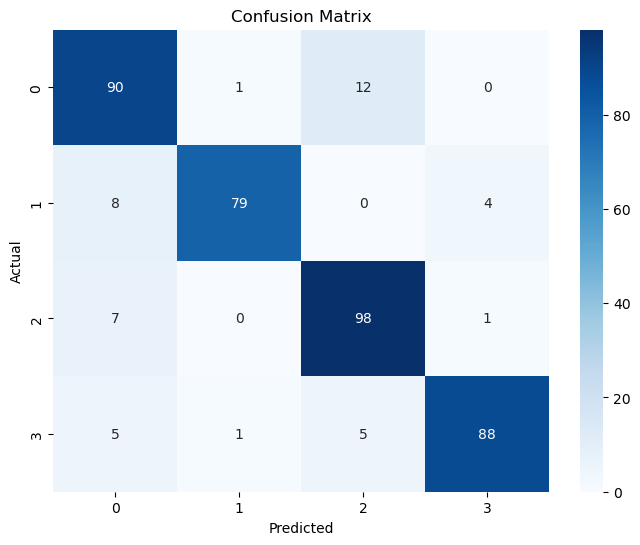

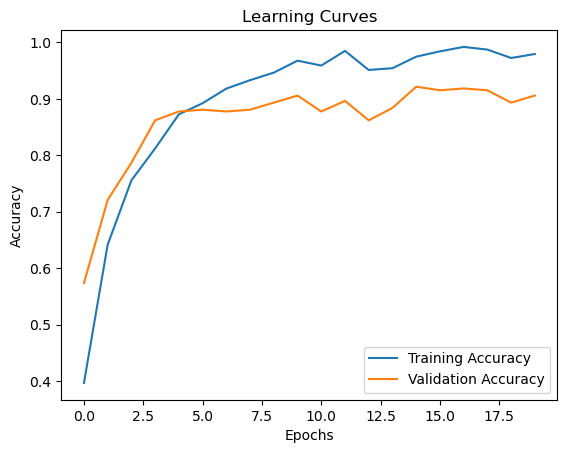

Precision: 0.894821222631398
Recall: 0.8897243107769424
F-score: 0.8907125978714195
MCC: 0.8535541020536898


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import shap

# Function to extract features from audio files
def extract_audio_features(audio_file, max_pad_len=100):
    try:
        # Load audio file
        y, sr = librosa.load(audio_file, sr=None)
        
        # Check if the audio signal is long enough for feature extraction
        if len(y) < 2048:
            return None
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        
        # Pad or truncate the features to ensure they have the same length
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        
        return mfccs
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

# Function to load audio data and extract features
def load_data(data_path, max_pad_len=100):
    X, y = [], []
    for label in os.listdir(data_path):
        label_dir = os.path.join(data_path, label)
        for file in os.listdir(label_dir):
            audio_file = os.path.join(label_dir, file)
            features = extract_audio_features(audio_file, max_pad_len)
            if features is not None:
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

# Define data path
data_path = r"C:\Users\hesham\OneDrive\سطح المكتب\torgo_data\train"

# Load data and encode labels
X, y = load_data(data_path)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define deep learning model with CNN and bidirectional LSTM
model = models.Sequential([
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Learning Curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Precision, Recall, F-score, MCC
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f_score = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", f_score)
print("MCC:", mcc)
